CSE 256: Assignment 1 Code

Name: Vignesh Nanda Kumar

PID: A59010704

In [32]:
# loading required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import learning_curve
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import spacy
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from tqdm.notebook import tqdm, trange

# downloading necessary word sets
nlp = spacy.load('en')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
def read_files(tarfname):
    """Read the training and development data from the sentiment tar file.
    The returned object contains various fields that store sentiment data, such as:

    train_data,dev_data: array of documents (array of words)
    train_fnames,dev_fnames: list of filenames of the doccuments (same length as data)
    train_labels,dev_labels: the true string label for each document (same length as data)

    The data is also preprocessed for use with scikit-learn, as:

    count_vec: CountVectorizer used to process the data (for reapplication on new data)
    trainX,devX: array of vectors representing Bags of Words, i.e. documents processed through the vectorizer
    le: LabelEncoder, i.e. a mapper from string labels to ints (stored for reapplication)
    target_labels: List of labels (same order as used in le)
    trainy,devy: array of int labels, one for each document
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name

    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    from sklearn.feature_extraction.text import CountVectorizer
    sentiment.count_vect = CountVectorizer()
    sentiment.trainX = sentiment.count_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.count_vect.transform(sentiment.dev_data)
    from sklearn import preprocessing
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment

def read_unlabeled(tarfname, sentiment):
    """Reads the unlabeled data.

    The returned object contains three fields that represent the unlabeled data.

    data: documents, represented as sequence of words
    fnames: list of filenames, one for each document
    X: bag of word vector for each document, using the sentiment.vectorizer
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    class Data: pass
    unlabeled = Data()
    unlabeled.data = []
    
    unlabeledname = "unlabeled.tsv"
    for member in tar.getmembers():
        if 'unlabeled.tsv' in member.name:
            unlabeledname = member.name
            
    print(unlabeledname)
    tf = tar.extractfile(unlabeledname)
    for line in tf:
        line = line.decode("utf-8")
        text = line.strip()
        unlabeled.data.append(text)
        
            
    unlabeled.X = sentiment.count_vect.transform(unlabeled.data)
    print(unlabeled.X.shape)
    tar.close()
    return unlabeled

def read_tsv(tar, fname):
    member = tar.getmember(fname)
    print(member.name)
    tf = tar.extractfile(member)
    data = []
    labels = []
    for line in tf:
        line = line.decode("utf-8")
        (label,text) = line.strip().split("\t")
        labels.append(label)
        data.append(text)
    return data, labels

def train_classifier(X, y, c):
	"""Train a classifier using the given training data.

	Trains logistic regression on the input data with default parameters.
	"""
	from sklearn.linear_model import LogisticRegression
	cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=c)
	cls.fit(X, y)
	return cls

def evaluate(X, yt, cls, name='data'):
	"""Evaluated a classifier on the given labeled data using accuracy."""
	from sklearn import metrics
	yp = cls.predict(X)
	acc = metrics.accuracy_score(yt, yp)
	print("  Accuracy on %s  is: %s" % (name, acc))



In [34]:
tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname)

-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels


# **2.1 Guided Feature Engineering: Apply grid search and plotting training and dev accuracy curves**

In [35]:
# Grid search
parameters = {
     'feat__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
     'lrclf__C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

text_clf = Pipeline([
  ('feat', TfidfVectorizer()),
  ('lrclf', LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)),])
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(sentiment.train_data, sentiment.trainy)
print(gs_clf.best_params_)

{'feat__ngram_range': (1, 2), 'lrclf__C': 3}


In [36]:
sentiment.tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
sentiment.new_trainX = sentiment.tfidf_vect.fit_transform(sentiment.train_data)
sentiment.new_devX = sentiment.tfidf_vect.transform(sentiment.dev_data)

In [37]:
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=3)
cls.fit(sentiment.new_trainX, sentiment.trainy)

LogisticRegression(C=3, max_iter=10000, random_state=0)

In [38]:
evaluate(sentiment.new_trainX, sentiment.trainy, cls, 'train')
evaluate(sentiment.new_devX, sentiment.devy, cls, 'dev')

  Accuracy on train  is: 0.9910519423832388
  Accuracy on dev  is: 0.777292576419214


In [39]:
# iterating over n and C values for plotting graphs for training and dev sets
n = 9
c_range = [i for i in range(1,21)]
n_vals = [i for i in range(1, n+1)]
acc_vals_train = []
acc_vals_dev = []

In [40]:
for i in range(n):
  n_val = n_vals[i]
  n_range = (1, n_val)
  tfidf_vect = TfidfVectorizer(ngram_range=n_range)
  new_trainX = tfidf_vect.fit_transform(sentiment.train_data)
  new_devX = tfidf_vect.transform(sentiment.dev_data)
  c_acc_vals_train = []
  c_acc_vals_dev = []
  for c in c_range:
    cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=c)
    cls.fit(new_trainX, sentiment.trainy)
    
    ytrain_pred = cls.predict(new_trainX)
    ydev_pred = cls.predict(new_devX)
    acc_train = metrics.accuracy_score(sentiment.trainy, ytrain_pred)
    acc_dev = metrics.accuracy_score(sentiment.devy, ydev_pred)
    c_acc_vals_train.append(acc_train)
    c_acc_vals_dev.append(acc_dev)
  print("done n:" + str(i))
  acc_vals_train.append(c_acc_vals_train)
  acc_vals_dev.append(c_acc_vals_dev)

done n:0
done n:1
done n:2
done n:3
done n:4
done n:5
done n:6
done n:7
done n:8


In [41]:
for n in range(5):
  print(n)
  for k in range(len(acc_vals_train[n])):
    print(k+1, acc_vals_train[n][k], end = ',')
  print()

0
1 0.9020078568310781,2 0.9279790484504583,3 0.9447839371453514,4 0.9559144478393714,5 0.9624618070711479,6 0.9681361850720209,7 0.9740288083806198,8 0.9781754692274116,9 0.9816673941510258,10 0.9851593190746399,11 0.9884329986905281,12 0.9903972064600611,13 0.9917066783064165,14 0.9927979048450458,15 0.9934526407682235,16 0.9941073766914011,17 0.994543867306853,18 0.9947621126145788,19 0.9954168485377565,20 0.9965080750763858,
1
1 0.9570056743780009,2 0.9818856394587516,3 0.9910519423832388,4 0.99628982976866,5 0.9978175469227412,6 0.9989087734613706,7 0.9993452640768223,8 0.9997817546922741,9 1.0,10 1.0,11 1.0,12 1.0,13 1.0,14 1.0,15 1.0,16 1.0,17 1.0,18 1.0,19 1.0,20 1.0,
2
1 0.9801396769969446,2 0.994543867306853,3 0.9984722828459188,4 0.9995635093845482,5 0.9997817546922741,6 1.0,7 1.0,8 1.0,9 1.0,10 1.0,11 1.0,12 1.0,13 1.0,14 1.0,15 1.0,16 1.0,17 1.0,18 1.0,19 1.0,20 1.0,
3
1 0.990615451767787,2 0.9984722828459188,3 0.9997817546922741,4 1.0,5 1.0,6 1.0,7 1.0,8 1.0,9 1.0,10 1.0,

In [42]:
for n in range(5):
  print(n)
  for k in range(len(acc_vals_dev[n])):
    print(k+1, acc_vals_dev[n][k], end = ',')
  print()

0
1 0.7663755458515283,2 0.7663755458515283,3 0.777292576419214,4 0.7903930131004366,5 0.7947598253275109,6 0.7947598253275109,7 0.7925764192139738,8 0.7882096069868996,9 0.7882096069868996,10 0.7903930131004366,11 0.7925764192139738,12 0.7925764192139738,13 0.7925764192139738,14 0.7925764192139738,15 0.7925764192139738,16 0.7925764192139738,17 0.7925764192139738,18 0.7925764192139738,19 0.7947598253275109,20 0.7925764192139738,
1
1 0.7707423580786026,2 0.7816593886462883,3 0.777292576419214,4 0.7838427947598253,5 0.7816593886462883,6 0.7816593886462883,7 0.7816593886462883,8 0.7838427947598253,9 0.7838427947598253,10 0.7882096069868996,11 0.7882096069868996,12 0.7882096069868996,13 0.7860262008733624,14 0.7860262008733624,15 0.7860262008733624,16 0.7882096069868996,17 0.7882096069868996,18 0.7903930131004366,19 0.7903930131004366,20 0.7903930131004366,
2
1 0.7707423580786026,2 0.7794759825327511,3 0.7816593886462883,4 0.7903930131004366,5 0.7882096069868996,6 0.7903930131004366,7 0.79

In [43]:
# plotting accuracies

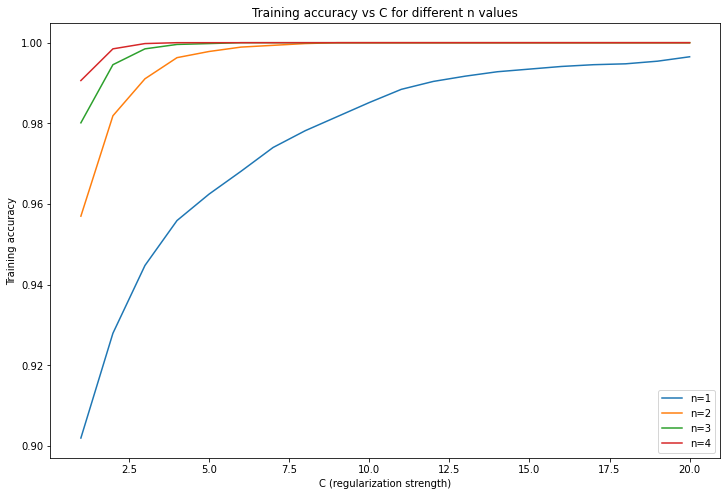

In [49]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["legend.loc"] = 'lower right'
plt.xlabel("C (regularization strength)")
plt.ylabel("Training accuracy")
plt.title("Training accuracy vs C for different n values")
for i in range(n):
  plt.plot(c_range, acc_vals_train[i], label="n="+str(i+1))
plt.legend()
plt.show()

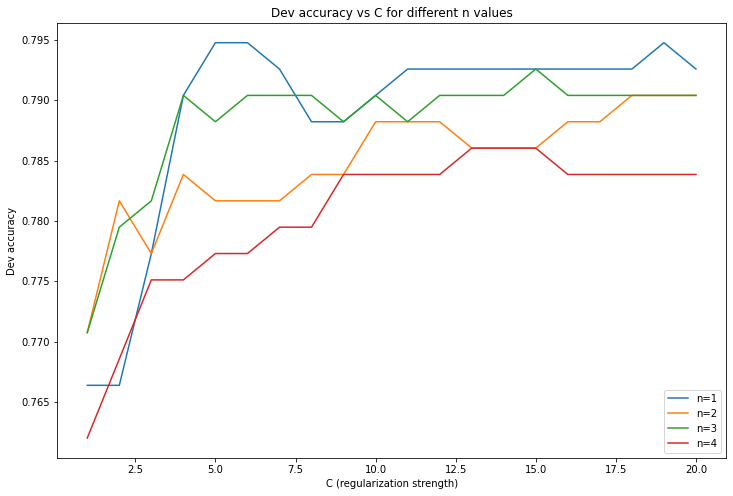

In [50]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["legend.loc"] = 'lower right'
plt.xlabel("C (regularization strength)")
plt.ylabel("Dev accuracy")
plt.title("Dev accuracy vs C for different n values")
for i in range(n):
  plt.plot(c_range, acc_vals_dev[i], label="n="+str(i+1))
plt.legend()
plt.show()

In [46]:
# performance for best n and C value (n=1, C=6)
sentiment.tfidf_vect = TfidfVectorizer(ngram_range=(1,1))
sentiment.new_trainX = sentiment.tfidf_vect.fit_transform(sentiment.train_data)
sentiment.new_devX = sentiment.tfidf_vect.transform(sentiment.dev_data)
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=6)
cls.fit(sentiment.new_trainX, sentiment.trainy)
evaluate(sentiment.new_trainX, sentiment.trainy, cls, 'train')
evaluate(sentiment.new_devX, sentiment.devy, cls, 'dev')

  Accuracy on train  is: 0.9681361850720209
  Accuracy on dev  is: 0.7947598253275109


In [47]:
# performance for next best n and C value (n=1, C=18)
sentiment.tfidf_vect = TfidfVectorizer(ngram_range=(1,1))
sentiment.new_trainX = sentiment.tfidf_vect.fit_transform(sentiment.train_data)
sentiment.new_devX = sentiment.tfidf_vect.transform(sentiment.dev_data)
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=18)
cls.fit(sentiment.new_trainX, sentiment.trainy)
evaluate(sentiment.new_trainX, sentiment.trainy, cls, 'train')
evaluate(sentiment.new_devX, sentiment.devy, cls, 'dev')

  Accuracy on train  is: 0.9947621126145788
  Accuracy on dev  is: 0.7925764192139738


In [48]:
# performance for next best n and C value (n=3, C=4)
sentiment.tfidf_vect = TfidfVectorizer(ngram_range=(1,3))
sentiment.new_trainX = sentiment.tfidf_vect.fit_transform(sentiment.train_data)
sentiment.new_devX = sentiment.tfidf_vect.transform(sentiment.dev_data)
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=4)
cls.fit(sentiment.new_trainX, sentiment.trainy)
evaluate(sentiment.new_trainX, sentiment.trainy, cls, 'train')
evaluate(sentiment.new_devX, sentiment.devy, cls, 'dev')

  Accuracy on train  is: 0.9995635093845482
  Accuracy on dev  is: 0.7903930131004366


<BarContainer object of 2 artists>

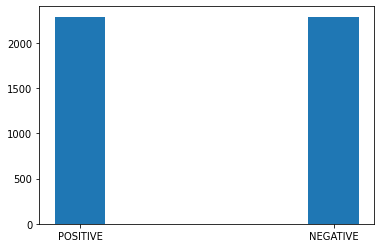

In [51]:
# seeing label distribution
plt.rcParams["figure.figsize"] = (6,4)
positive_train_count = sentiment.train_labels.count('POSITIVE')
negative_train_count = sentiment.train_labels.count('NEGATIVE')
labels = ['POSITIVE', 'NEGATIVE']
counts = [positive_train_count, negative_train_count]
plt.bar(labels, counts, width=0.2)

# **2.2 Independent Feature Engineering**

In [52]:
# helper functions for adding features to the data

# stop word removal
def preprocess_sentence(sentence, stopwords_list=None):
  basic_text = sentence.lower()
  
  words = basic_text.split()
  proc_words = []
  if stopwords_list is not None:
    for w in words:
      if w not in stopwords_list:
        proc_words.append(w)
  
  proc_sentence = " ".join(words)
  if len(proc_words) > 0:
    proc_sentence = " ".join(proc_words)
  return proc_sentence

# counting words
def count_words(sentence):
  return len(sentence.split())

# count number of adjectives
def get_nadjectives(sentence, nlp_model):
  nadj = 0
  doc = nlp_model(sentence)
  for i, token in enumerate(doc):
    if doc[i].pos_ == 'ADJ':
      nadj += 1
  return nadj

# count number of verbs
def get_nverbs(sentence, nlp_model):
  nverbs = 0
  doc = nlp_model(sentence)
  for i, token in enumerate(doc):
    if doc[i].pos_ == 'VERB':
      nverbs += 1
  return nverbs

# count number of positive words
def get_number_pos_words(sentence):
  npos = 0
  words = sentence.split()
  for w in words:
    pol = TextBlob(w).sentiment.polarity
    if pol > 0.2:
      npos += 1
  return npos

# count number of negative words
def get_number_neg_words(sentence):
  nneg = 0
  words = sentence.split()
  for w in words:
    pol = TextBlob(w).sentiment.polarity
    if pol < -0.2:
      nneg += 1
  return nneg
# compute polarity of sentence
def get_polarity(sentence):
  return TextBlob(sentence).sentiment.polarity

def compute_additional_features(df):
  # Reference: https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
  df["word_count"] = df["sentences"].apply(lambda s: count_words(s))
  df['char_count'] = df["sentences"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
  df['sentence_count'] = df["sentences"].apply(lambda x: len(str(x).split(".")))
  df['avg_word_length'] = df['char_count'] / df['word_count']
  df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
  df["num_adjectives"] = df["sentences"].apply(lambda s: get_nadjectives(s, nlp))
  df["num_verbs"] = df["sentences"].apply(lambda s: get_nverbs(s, nlp))
  df['npositive_words'] = df["sentences"].apply(lambda s: get_number_pos_words(s))
  df['nnegative_words'] = df["sentences"].apply(lambda s: get_number_neg_words(s))
  df['polarity'] = df["sentences"].apply(lambda s: get_polarity(s))
  return df

In [53]:
# loading dataset as pandas dataframe for analysis
data_df = pd.DataFrame({"sentences":sentiment.train_data, "labels":sentiment.train_labels})
dev_df = pd.DataFrame({"sentences":sentiment.dev_data, "labels":sentiment.dev_labels})



In [67]:
# computing features for the training and dev data
data_df = compute_additional_features(data_df)
dev_df = compute_additional_features(dev_df)

In [ ]:
dev_df = compute_additional_features(dev_df)

In [68]:
import seaborn as sns
# Reference: https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
def plot_distribution_feature(feature_name):
  x, y = feature_name, "labels"
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(x, fontsize=12)
  for i in data_df[y].unique():
      sns.distplot(data_df[data_df[y]==i][x], hist=True, kde=False, 
                  bins=10, hist_kws={"alpha":0.8}, 
                  axlabel="histogram", ax=ax[0])
      sns.distplot(data_df[data_df[y]==i][x], hist=False, kde=True, 
                  kde_kws={"shade":True}, axlabel="density",   
                  ax=ax[1])
  ax[0].grid(True)
  ax[0].legend(data_df[y].unique())
  ax[1].grid(True)
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

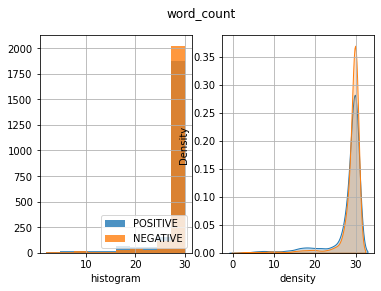

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

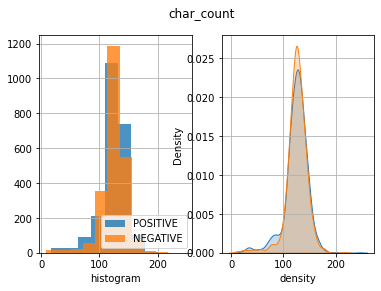

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

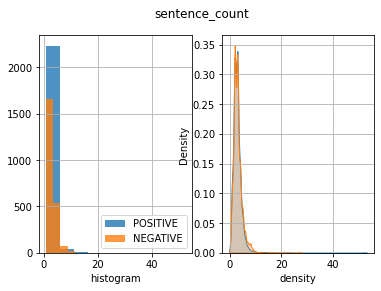

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

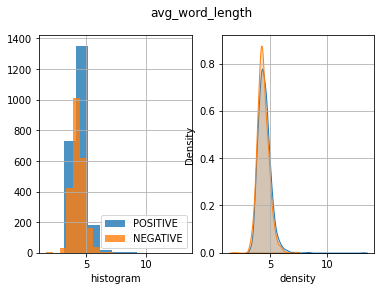

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

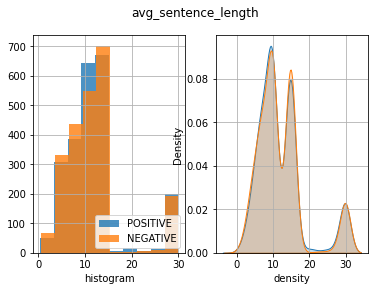

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

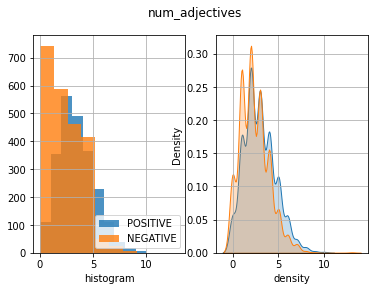

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

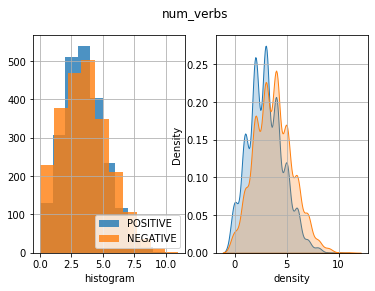

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

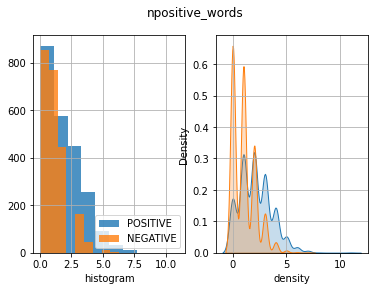

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

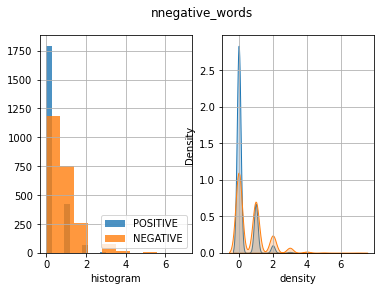

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

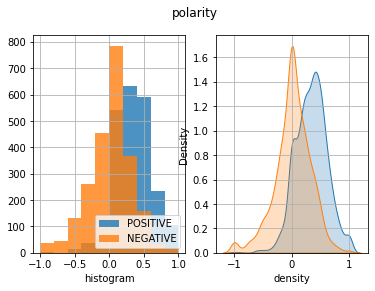

In [69]:
# checking new feature distribution plots
new_features = data_df.columns[2:]
for f in new_features:
  plot_distribution_feature(f)

In [70]:
# Reference: https://gist.github.com/4OH4/f727af7dfc0e6bb0f26d2ea41d89ee55
# trying out different tokenizers
class StemTokenizer:
  ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
  def __init__(self):
      self.ps = PorterStemmer()
  def __call__(self, doc):
      return [self.ps.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

lem_tokenizer = LemmaTokenizer()
stem_tokenizer = StemTokenizer()
token_stop = lem_tokenizer(' '.join(stop_words))

In [71]:
# stop words removal
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=token_stop)
new_trainX = vectorizer.fit_transform(sentiment.train_data)
new_devX = vectorizer.transform(sentiment.dev_data)
st_cls = train_classifier(new_trainX, sentiment.trainy, 1)
evaluate(new_trainX, sentiment.trainy, st_cls, 'train')
evaluate(new_devX, sentiment.devy, st_cls, 'dev')

  Accuracy on train  is: 0.9044085552160629
  Accuracy on dev  is: 0.759825327510917


In [72]:
# lemmatizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), tokenizer=lem_tokenizer)
new_trainX = vectorizer.fit_transform(sentiment.train_data)
new_devX = vectorizer.transform(sentiment.dev_data)
st_cls = train_classifier(new_trainX, sentiment.trainy,1)
evaluate(new_trainX, sentiment.trainy, st_cls, 'train')
evaluate(new_devX, sentiment.devy, st_cls, 'dev')

  Accuracy on train  is: 0.896551724137931
  Accuracy on dev  is: 0.7663755458515283


In [73]:
# stem tokenizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), tokenizer=stem_tokenizer)
new_trainX = vectorizer.fit_transform(sentiment.train_data)
new_devX = vectorizer.transform(sentiment.dev_data)
st_cls = train_classifier(new_trainX, sentiment.trainy,1)
evaluate(new_trainX, sentiment.trainy, st_cls, 'train')
evaluate(new_devX, sentiment.devy, st_cls, 'dev')

  Accuracy on train  is: 0.8878219118288957
  Accuracy on dev  is: 0.759825327510917


In [74]:
from scipy.sparse import hstack
def get_augmented_dataset(tf_idf_data, feature_name, data_df):
  feat_vec = np.array(data_df[feature_name])
  return hstack((tf_idf_data, feat_vec.reshape(-1, 1)))

In [75]:
# tf idf vectorizer for the next few feature additions
vectorizer = TfidfVectorizer(ngram_range=(1,1))
new_trainX = vectorizer.fit_transform(sentiment.train_data)
new_devX = vectorizer.transform(sentiment.dev_data)

In [76]:
# word count
trainX = get_augmented_dataset(new_trainX, "word_count", data_df)
devX = get_augmented_dataset(new_devX, "word_count", dev_df)
cls_add = train_classifier(trainX, sentiment.trainy,1)
evaluate(trainX, sentiment.trainy, cls_add, 'train')
evaluate(devX, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.8987341772151899
  Accuracy on dev  is: 0.7532751091703057


In [77]:
# character count
trainX = get_augmented_dataset(new_trainX, "char_count", data_df)
devX = get_augmented_dataset(new_devX, "char_count", dev_df)
cls_add = train_classifier(trainX, sentiment.trainy,1)
evaluate(trainX, sentiment.trainy, cls_add, 'train')
evaluate(devX, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.8993889131383676
  Accuracy on dev  is: 0.759825327510917


In [78]:
# avg word length count
trainX = get_augmented_dataset(new_trainX, "avg_word_length", data_df)
devX = get_augmented_dataset(new_devX, "avg_word_length", dev_df)
cls_add = train_classifier(trainX, sentiment.trainy,1)
evaluate(trainX, sentiment.trainy, cls_add, 'train')
evaluate(devX, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.9006983849847229
  Accuracy on dev  is: 0.7620087336244541


In [79]:
# number of adjectives
trainX = get_augmented_dataset(new_trainX, "num_adjectives", data_df)
devX = get_augmented_dataset(new_devX, "num_adjectives", dev_df)
cls_add = train_classifier(trainX, sentiment.trainy,1)
evaluate(trainX, sentiment.trainy, cls_add, 'train')
evaluate(devX, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.8950240069838499
  Accuracy on dev  is: 0.7663755458515283


In [80]:
# number of verbs
trainX = get_augmented_dataset(new_trainX, "num_verbs", data_df)
devX = get_augmented_dataset(new_devX, "num_verbs", dev_df)
cls_add = train_classifier(trainX, sentiment.trainy,1)
evaluate(trainX, sentiment.trainy, cls_add, 'train')
evaluate(devX, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.8880401571366215
  Accuracy on dev  is: 0.759825327510917


In [81]:
# polarity
trainX = get_augmented_dataset(new_trainX, "polarity", data_df)
devX = get_augmented_dataset(new_devX, "polarity", dev_df)
cls_add = train_classifier(trainX, sentiment.trainy,1)
evaluate(trainX, sentiment.trainy, cls_add, 'train')
evaluate(devX, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.860977738978612
  Accuracy on dev  is: 0.7882096069868996


In [82]:
# number of positve and negative words 
npos = np.array(data_df["npositive_words"])
nneg = np.array(data_df["nnegative_words"])
X_train_tfidf = hstack((new_trainX, npos.reshape(-1, 1), nneg.reshape(-1, 1)))

In [83]:
npos = np.array(dev_df["npositive_words"])
nneg = np.array(dev_df["nnegative_words"])
X_dev_tfidf = hstack((new_devX, npos.reshape(-1, 1), nneg.reshape(-1, 1)))

In [84]:
cls_add = train_classifier(X_train_tfidf, sentiment.trainy,1)
evaluate(X_train_tfidf, sentiment.trainy, cls_add, 'train')
evaluate(X_dev_tfidf, sentiment.devy, cls_add, 'dev')

  Accuracy on train  is: 0.8644696639022261
  Accuracy on dev  is: 0.7816593886462883
